_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*Florian Burkhardt & Franz Ruppert* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? ChatGPT for explanation of concepts, coding assistance, plotting assistance* </span>

# Project 3: Single-cell data analysis.

In [133]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

from sklearn.decomposition import PCA
import time
import pickle
import scanpy as sc
import anndata
from sklearn.manifold import TSNE
import umap

from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from scipy.special import gammaln
from scipy.stats import nbinom
from sklearn.preprocessing import normalize

from pathlib import Path

In [87]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [88]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [89]:
plt.style.use("../matplotlib_style.txt")

In [90]:
np.random.seed(42)

## Project and data description

In this project, we are going to work with the typical methods and pipelines used in single-cell data analysis and get some hands-on experience with the techniques used in the field. For that, we will be using Patch-seq multimodal data from cortical neurons in mice, from Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). From the different data modalities they used, we will focus on transcriptomics and electrophysiological data. 

In a real-world scenario, single cell data rarely comes with any "ground truth" labels. Often, the goal of researchers after measuring cells is to precisely classify them, grouping them into families or assigning them cell types based on the recorded features. This is normally done using usupervised methods, such as clustering methods.

However, the single-cell data that we are using in this project has some cell types assigned to each cell. These are not "ground truth" type annotations, but were one of the results from the original Scala et al. work. Still, we are going to use those annotations for validation (despite them not really being ground truth) to sanity-check some of our analyses, such as visualizations, clustering, etc. We will mainly work with cell types (`rna_types`, 77 unique types) and cell families (`rna_families`, 9 unique families).

From the transcriptomics mRNA counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out.

## Import data

### Meta data

In [91]:
# META DATA

meta = pd.read_csv(
    "../data/project-03/m1_patchseq_meta_data.csv",
    sep="\t",
)

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### "Ground truth labels"

In [92]:
# filter out low quality cells in term of RNA
print(
    "There are",
    np.sum(meta["RNA family"] == "low quality"),
    "cells with low quality RNA recordings.",
)
exclude_low_quality = meta["RNA family"] != "low quality"

There are 97 cells with low quality RNA recordings.


In [93]:
rna_family = meta["RNA family"][exclude_low_quality]
rna_type = meta["RNA type"][exclude_low_quality]

In [94]:
meta.columns

Index(['Number', 'Cell', 'Slice', 'Date', 'Sample', 'Mouse',
       'Mouse date of birth', 'Mouse age', 'Mouse gender', 'Mouse genotype',
       'Targeted layer', 'Inferred layer', 'Cre', 'Exon reads', 'Intron reads',
       'Intergenic reads', 'Sequencing batch', 'Number of genes detected',
       'RNA family', 'RNA type', 'RNA type confidence', 'RNA type top-3',
       'ALM/VISp top-3', 'Length (bp)', 'Yield (pg/µl)', 'User',
       'Hold Time (min)', 'Soma depth (µm)', 'Soma depth (4x)',
       'Cortical thickness (4x)', 'Cortical thickness (µm)', 'Traced',
       'Exclusion reasons'],
      dtype='object')

In [95]:
print(len(np.unique(rna_family)))
print(len(np.unique(rna_type)))

9
77


In [96]:
pickle_in = open(
    "../data/project-03/dict_rna_type_colors.pkl",
    "rb",
)
dict_rna_type_colors = pickle.load(pickle_in)

In [97]:
rna_type_colors = np.vectorize(dict_rna_type_colors.get)(rna_type)

### Transcriptomic data

In [98]:
# READ COUNTS
data_exons = pd.read_csv(
    "../data/project-03/m1_patchseq_exon_counts.csv.gz",
    na_filter=False,
    index_col=0,
)

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

# filter out low quality cells in term of rna family
exonCounts = data_exons.values.transpose()[exclude_low_quality]
print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1232, 42466)


In [99]:
# GENE LENGTH

data = pd.read_csv("../data/project-03/gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values

In [100]:
exonLengths.shape

(42466,)

### Electrophysiological features

In [101]:
# EPHYS DATA

ephysData = pd.read_csv("../data/project-03/m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [102]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]
ephysNames_filtered = ephysNames[~np.isin(ephysNames, features_exclude)]
X = ephysData[exclude_low_quality]
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1232, 29)
(1224, 17)


In [103]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

# Research questions to investigate

**1) Inspect the data by computing key statistics.** For RNA counts, you can compute and plot statistics, e.g. total counts per cell, number of expressed genes per cell, mean count per gene, variance per gene, mean-variance relationship... See https://www.embopress.org/doi/full/10.15252/msb.20188746 for common quality control statistics. Keep in mind that the RNA data in this project is read counts, not UMI counts, so it is not supposed to follow a Poisson distribution. To get an idea of the technical noise in the data, you can plot count distributions of single genes within cell types (like in the lecture). 

Similarly, you can compute and plot statistics over the electrophyiological data. Also, investigate the distribution of "ground truth" labels. Comment about other relevant metadata, and think if you can use it as some external validation for other analyses. If you do use other metadata throughout the project, explain why and what you get out of it. Take into account that certain features may not be very informative for our purposes (e.g. mouse age), so only choose features that provide you with useful information in this context. If you want to get additional information about the metadata, have a look at the extended data section in the original publication (e.g., cre-lines in Figure 1c in the extended data).

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

**3) Two-dimensional visualization.** To visualize the RNA count data after normalization, transformation, gene selection and PCA, try different methods (just PCA, t-SNE, UMAP, ..) and vary their parameters (exaggeration, perplexity, ..). Compare them using quantitative metrics (e.g., kNN accuracy in high-dim vs. two-dim, kNN recall). Please refer to Lause et al., 2024 (https://doi.org/10.1371/journal.pcbi.1012403) where many of these metrics are discussed and explained to make an informed choice on which metrics to use. Think about also using the electrophysiological features and other metadata to enhance different visualizations.

**4) Clustering.** To find cell types in the RNA count data, you will need to look for clusters. Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2). Feel free to simplify the setup from the paper and not optimize over the set of important genes S but fix it instead, or skip the split and merge part of their clustering algorithm. A vanilla NBMM implementation should suffice. Take into account that the NBMM tries to cluster data that follows a negative binomial distribution. Therefore, it does not make sense to apply this clustering method to all kinds of normalized and transformed data. Please refer to the Harris et al. 2018 publication for the appropriate choice of normalization, and reflect on why this normalization makes sense. Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation between electrophysiological features and genes/PCs.** Finally, connect RNA counts and functional data: Most likely, there will be interesting relationships between the transcriptomic and electrophyiological features in this data. Find these correlations and a way of visualizing them. In studying correlations using the PCA-reduced version of the transcriptomics data, it could be interesting to study PC loadings to see which genes are dominating which PCs. For other advanced analyses, you can get inspitation from Kobak et al., 2021 (https://doi.org/10.1111/rssc.12494).
    

### Scanpy

We will be using the scanpy package for the majority of the analysis, as it is the state of the art package to analyse single-cell RNA sequencing data in python. We start by creating an AnnData object.

In [104]:
adata = anndata.AnnData(X=exonCounts)
adata.obs_names = cells[exclude_low_quality]

# Add gene names
meta_indexed = meta.set_index("Cell")
# Reindex to adata.obs_names to ensure correct order and alignment
meta_aligned = meta_indexed.reindex(adata.obs_names)
# Join the aligned meta info into adata.obs
adata.obs[
    [
        "rna_family",
        "rna_type",
        "target_layer",
        "inferred_layer",
        "soma_depth",
        "cre",
    ]
] = meta_aligned[
    [
        "RNA family",
        "RNA type",
        "Targeted layer",
        "Inferred layer",
        "Soma depth (µm)",
        "Cre",
    ]
]
ephys_cells_filtered = adata.obs_names[keepcells]
ephys_df_filtered = pd.DataFrame(
    ephysData_filtered, columns=ephysNames_filtered, index=ephys_cells_filtered
)
# Subset adata to only those cells with valid ephys data
adata = adata[ephys_df_filtered.index, :].copy()

# Merge ephys data into obs
adata.obs = adata.obs.join(ephys_df_filtered)

adata.var["exon_bp"] = (
    exonLengths  # transform from base pairs to kilobase for rpkm
)

### Count-Statistics

First, we will look at different count statistics to decide on exclusion criteria so that our analysis of the single cell gene expression data is based on viable cells. In accordance to Luecken & Theis, 2019 we are looking at count depth per cell, number of genes per cell, the count depth distribution from high to low count depths as well as the number of genes by count depth. As performed in the lecture, we will also look at the mean to variance distribution as well as mean and variance per cell.

In [105]:
# We start by computing standard quality control statistics.
sc.pp.calculate_qc_metrics(adata, inplace=True)

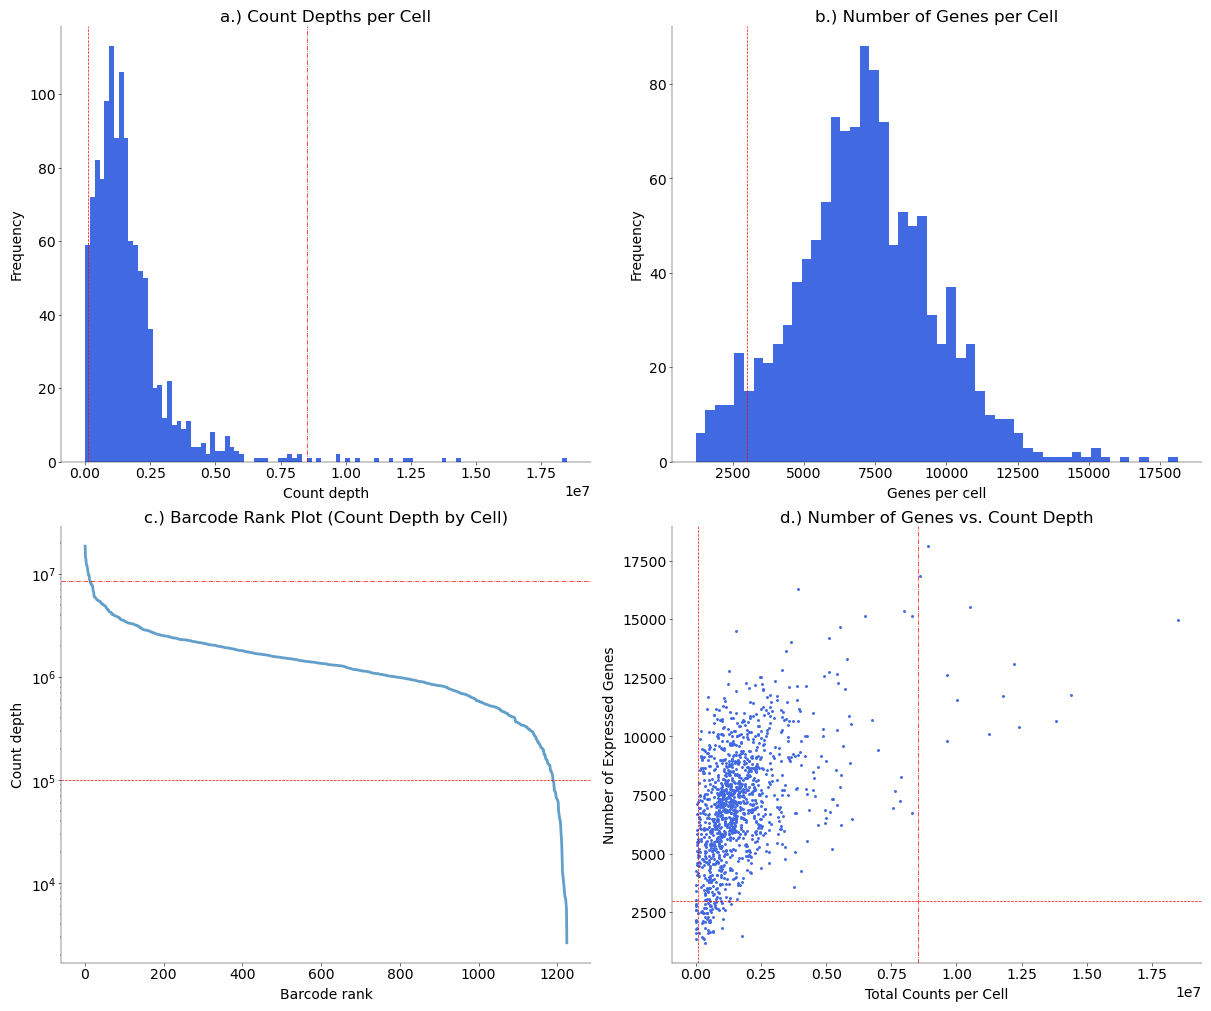

In [106]:
count_depth = adata.obs["total_counts"].values
genes = adata.obs["n_genes_by_counts"].values

sorted_depths = np.sort(count_depth)[::-1]
ranks = np.arange(1, len(sorted_depths) + 1)

#
count_thresh_low = 1e5
count_thresh_high = np.percentile(adata.obs["total_counts"], 99)
gene_thresh = 3000

fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

axes[0, 0].hist(count_depth, bins=100, color="royalblue")
axes[0, 0].axvline(
    count_thresh_low,
    color="red",
    linestyle="--",
    linewidth=0.5,
    label=f"Low Threshold = {count_thresh_low}",
)
axes[0, 0].axvline(
    count_thresh_high,
    color="red",
    linestyle="-.",
    linewidth=0.5,
    label=f"High Threshold = {count_thresh_high}",
)
axes[0, 0].set_xlabel("Count depth")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("a.) Count Depths per Cell")


axes[0, 1].hist(genes, bins=50, color="royalblue")
axes[0, 1].axvline(
    gene_thresh,
    color="red",
    linestyle="--",
    linewidth=0.5,
    label=f"Threshold = {gene_thresh}",
)
axes[0, 1].set_xlabel("Genes per cell")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("b.) Number of Genes per Cell")


axes[1, 0].plot(ranks, sorted_depths, linewidth=2, alpha=0.7)
axes[1, 0].axhline(
    count_thresh_low,
    color="red",
    linestyle="--",
    linewidth=0.5,
    label=f"Low Threshold = {count_thresh_low}",
)
axes[1, 0].axhline(
    count_thresh_high,
    color="red",
    linestyle="-.",
    linewidth=0.5,
    label=f"High Threshold = {count_thresh_high}",
)

axes[1, 0].set_xscale("linear")
axes[1, 0].set_yscale("log")
axes[1, 0].set_xlabel("Barcode rank")
axes[1, 0].set_ylabel("Count depth")
axes[1, 0].set_title("c.) Barcode Rank Plot (Count Depth by Cell)")

# ---- Bottom Right: Scatter plot (counts vs genes) ----
axes[1, 1].scatter(count_depth, genes, s=5, alpha=1, color="royalblue")
axes[1, 1].axvline(
    count_thresh_low,
    color="red",
    linestyle="--",
    linewidth=0.5,
    label=f"Low Threshold = {count_thresh_low}",
)
axes[1, 1].axvline(
    count_thresh_high,
    color="red",
    linestyle="-.",
    linewidth=0.5,
    label=f"High Threshold = {count_thresh_high}",
)
axes[1, 1].axhline(gene_thresh, color="red", linestyle="--", linewidth=0.5)
axes[1, 1].set_xlabel("Total Counts per Cell")
axes[1, 1].set_ylabel("Number of Expressed Genes")
axes[1, 1].set_title("d.) Number of Genes vs. Count Depth")

# Adjust layout
plt.show()

a.) The Histogram of the count depth is heavily right skewed which is to be expected. Most cells have a count depth of 500.000 to 2.500.000, with some very larger outliers > 10.000.000 which could be due to dublets. We apply conservative threshholds at 500.000 count as a low threshold and the 99th percentile as a high threshhold. b.) The number of genes per cell is nicely distributed with most cells having between 5.000 - 10.000 genes per cell. There is a small peak around 2.500 that could be noise so it is filtered out by the depicted threshold at 3.000 genes. c.) This is the distribution of Count depth from high to low count depth as a log-log plot. It shows that there are two elbows around where we set our thresholds. d.) The joint plotting of expressed genes and count depth shows the effect of the applied thresholds. It shows that we keep a large amount of cells which is in line with our desire to apply conservative thresholds - keep as many cells as possible for downstream analyisis. 

In [107]:
## Apply filter

filtered_adata = adata[
    (adata.obs["total_counts"] >= count_thresh_low)
    & (adata.obs["total_counts"] <= count_thresh_high)
    & (adata.obs["n_genes_by_counts"] >= gene_thresh),
    :,
].copy()

print(f"Original cells: {adata.n_obs}")
print(f"Filtered cells: {filtered_adata.n_obs}")

Original cells: 1224
Filtered cells: 1119


### Filter
After filtering in line with the Quality Control metrics described in Luecken & Theis, 2019 we keep 1.119 cells.

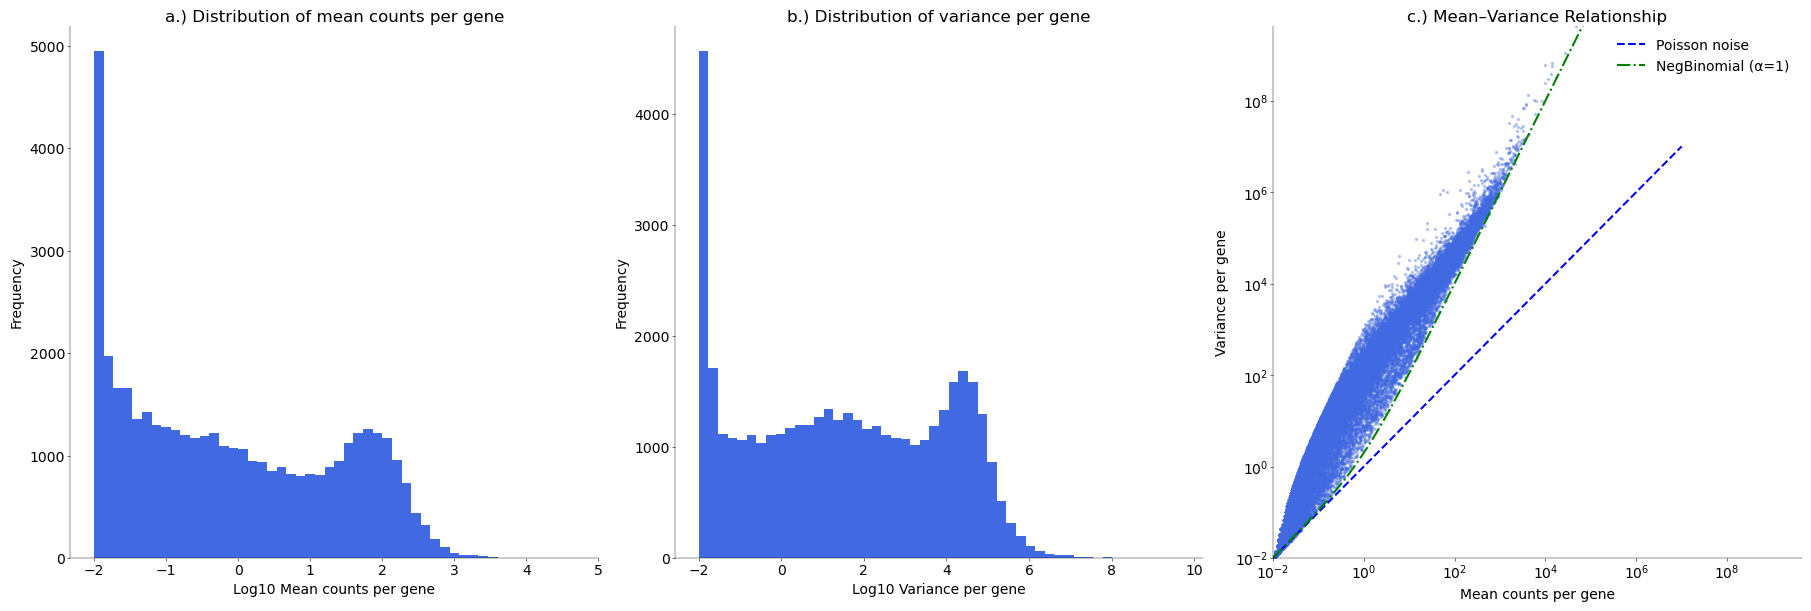

In [108]:
X = (
    filtered_adata.X.toarray()
    if hasattr(filtered_adata.X, "toarray")
    else filtered_adata.X
)

mean_counts_per_gene = X.mean(axis=0)
var_counts_per_gene = X.var(axis=0)


mean_adj = mean_counts_per_gene + 1e-2
var_adj = var_counts_per_gene + 1e-2


log_mean = np.log10(mean_adj)
log_var = np.log10(var_adj)


fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)


axs[0].hist(log_mean, bins=50, color="royalblue")
axs[0].set_xlabel("Log10 Mean counts per gene")
axs[0].set_ylabel("Frequency")
axs[0].set_title("a.) Distribution of mean counts per gene")


axs[1].hist(log_var, bins=50, color="royalblue")
axs[1].set_xlabel("Log10 Variance per gene")
axs[1].set_ylabel("Frequency")
axs[1].set_title("b.) Distribution of variance per gene")

# Scatter plot mean vs variance with log-log scale
min_val = min(mean_adj.min(), var_adj.min())
max_val = max(mean_adj.max(), var_adj.max())

axs[2].scatter(mean_adj, var_adj, alpha=0.3, s=8, color="royalblue")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlim(min_val, max_val)
axs[2].set_ylim(min_val, max_val)

axs[2].plot(
    [min_val, 1e7],
    [min_val, 1e7],
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label="Poisson noise",
)


alpha = 1
mu_range = np.logspace(np.log10(min_val), np.log10(max_val), 500)
nb_variance = mu_range + alpha * mu_range**2
axs[2].plot(
    mu_range,
    nb_variance,
    color="green",
    linestyle="-.",
    linewidth=1.5,
    label=f"NegBinomial (α={alpha})",
)

axs[2].set_xlabel("Mean counts per gene")
axs[2].set_ylabel("Variance per gene")
axs[2].set_title("c.) Mean–Variance Relationship")
axs[2].legend()

plt.show()

a & b.) Mean and Variance per gene are shown after applying log10 transformation for better visualization. The distribution looks very similar with variance being around double the mean. c.) The variance to mean plot shows the overdispersed nature of the count data. A poisson expectation is shown in the blue line and a better fitting neg-binomial expectation is shown in the green line. We assume that the technical noise of the count data does not follow a poisson distribution as it is not UMI counts but that it follows a negative binomial distribution with overdispersion parameter alpha = 1

### Electrophysiological features

As a second step we look at the distributions of the different electrophysiological features as well as their intercorrelation.

In [109]:
df_ephys.columns

Index(['AP amplitude (mV)', 'AP amplitude adaptation index',
       'AP coefficient of variation', 'AP threshold (mV)', 'AP width (ms)',
       'Afterhyperpolarization (mV)', 'ISI adaptation index',
       'ISI coefficient of variation', 'Input resistance (MOhm)',
       'Latency (ms)', 'Max number of APs', 'Membrane time constant (ms)',
       'Rebound (mV)', 'Resting membrane potential (mV)', 'Rheobase (pA)',
       'Sag ratio', 'Upstroke-to-downstroke ratio'],
      dtype='object')

C:\Users\Florian\AppData\Local\Temp\ipykernel_15132\835328435.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=9)


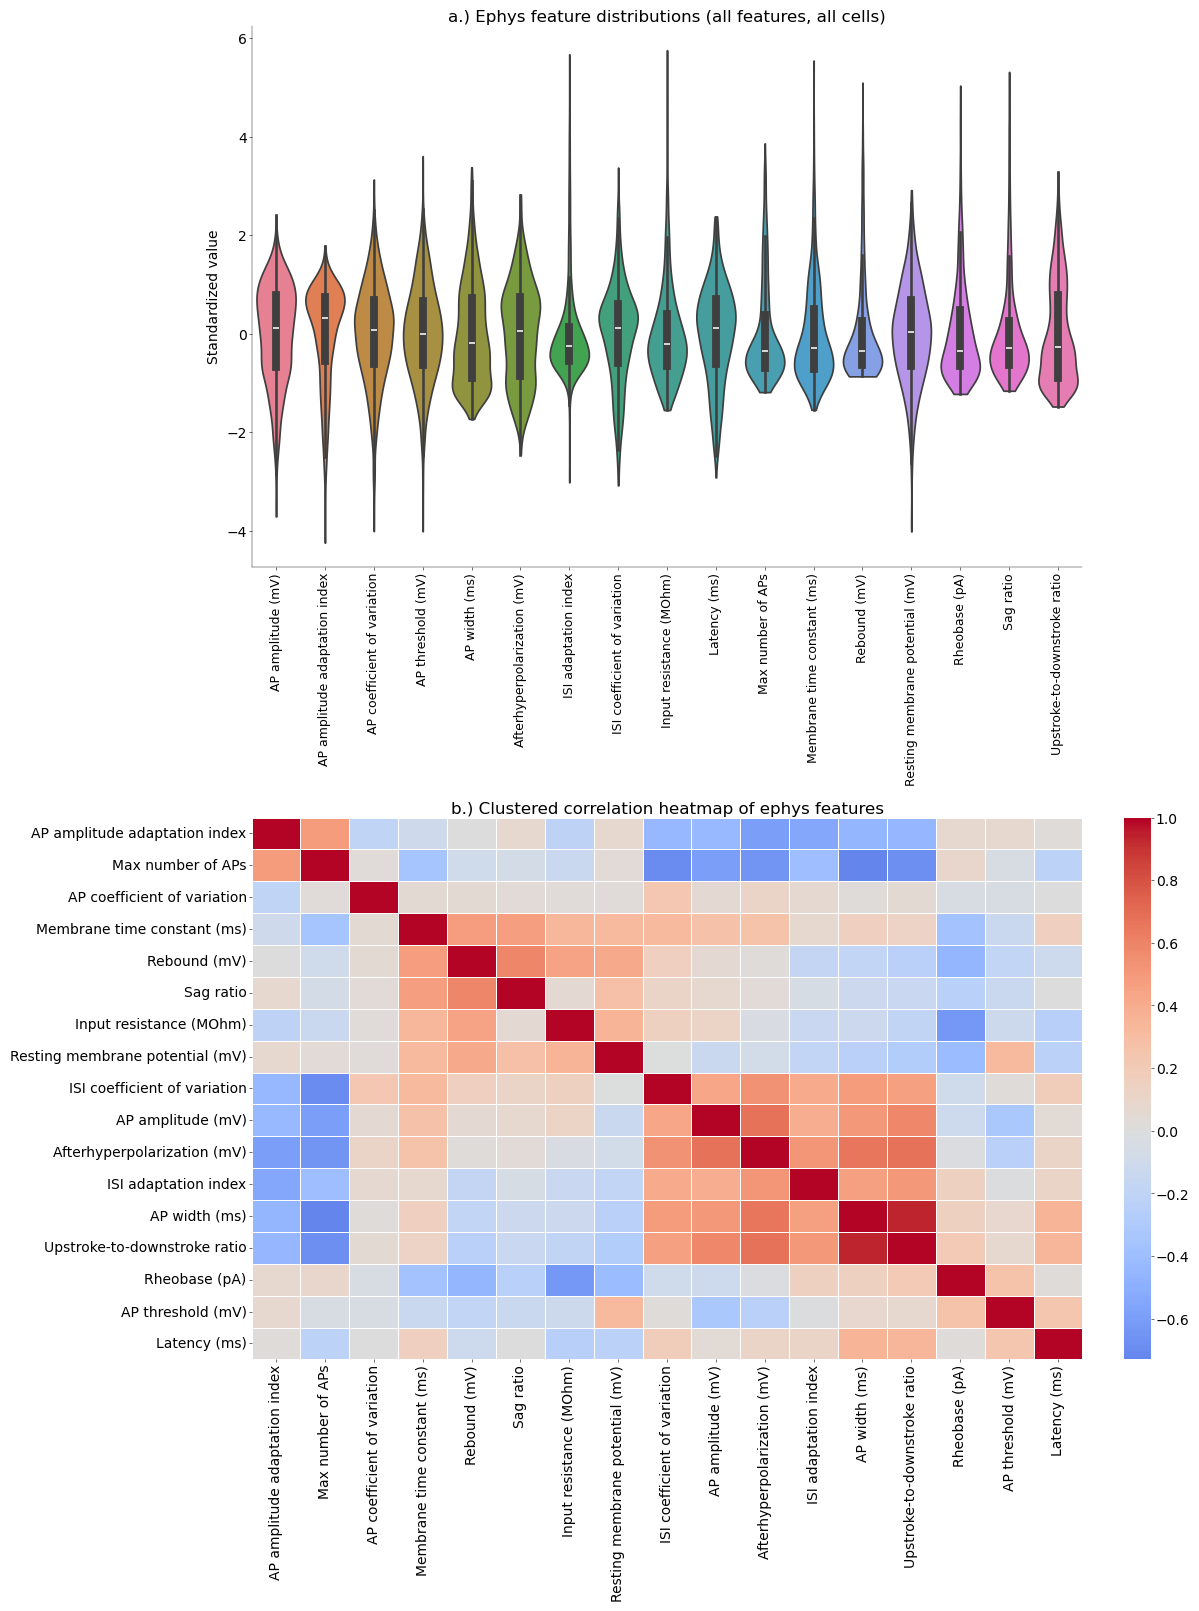

In [110]:
from scipy.cluster.hierarchy import linkage, leaves_list


df_ephys = filtered_adata.obs[ephysNames_filtered]


corr_matrix = df_ephys.corr()
order = leaves_list(linkage(corr_matrix, method="average"))
ordered_corr = corr_matrix.values[order][:, order]
ordered_labels = corr_matrix.columns[order]

fig, axes = plt.subplots(
    2,
    1,
    figsize=(max(10, len(ephysNames_filtered) * 0.7), 16),
    constrained_layout=True,
)


sns.violinplot(data=df_ephys, cut=0, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=9)
axes[0].set_ylabel("Standardized value")
axes[0].set_title("a.) Ephys feature distributions (all features, all cells)")


sns.heatmap(
    ordered_corr,
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    ax=axes[1],
)
axes[1].set_title("b.) Clustered correlation heatmap of ephys features")


plt.show()

a.) All standardized electrophysiological data looks reasonably distributed with some right tailed features like Max Number of APs, Rebound or Rheobase. b.) Some features are strongly correlated, like AP width and Upstroke-to-downstroke ratio which is to be expected.

### Ground truth distribution

Next we look at the distribution of our "ground truth" rna types and rna families

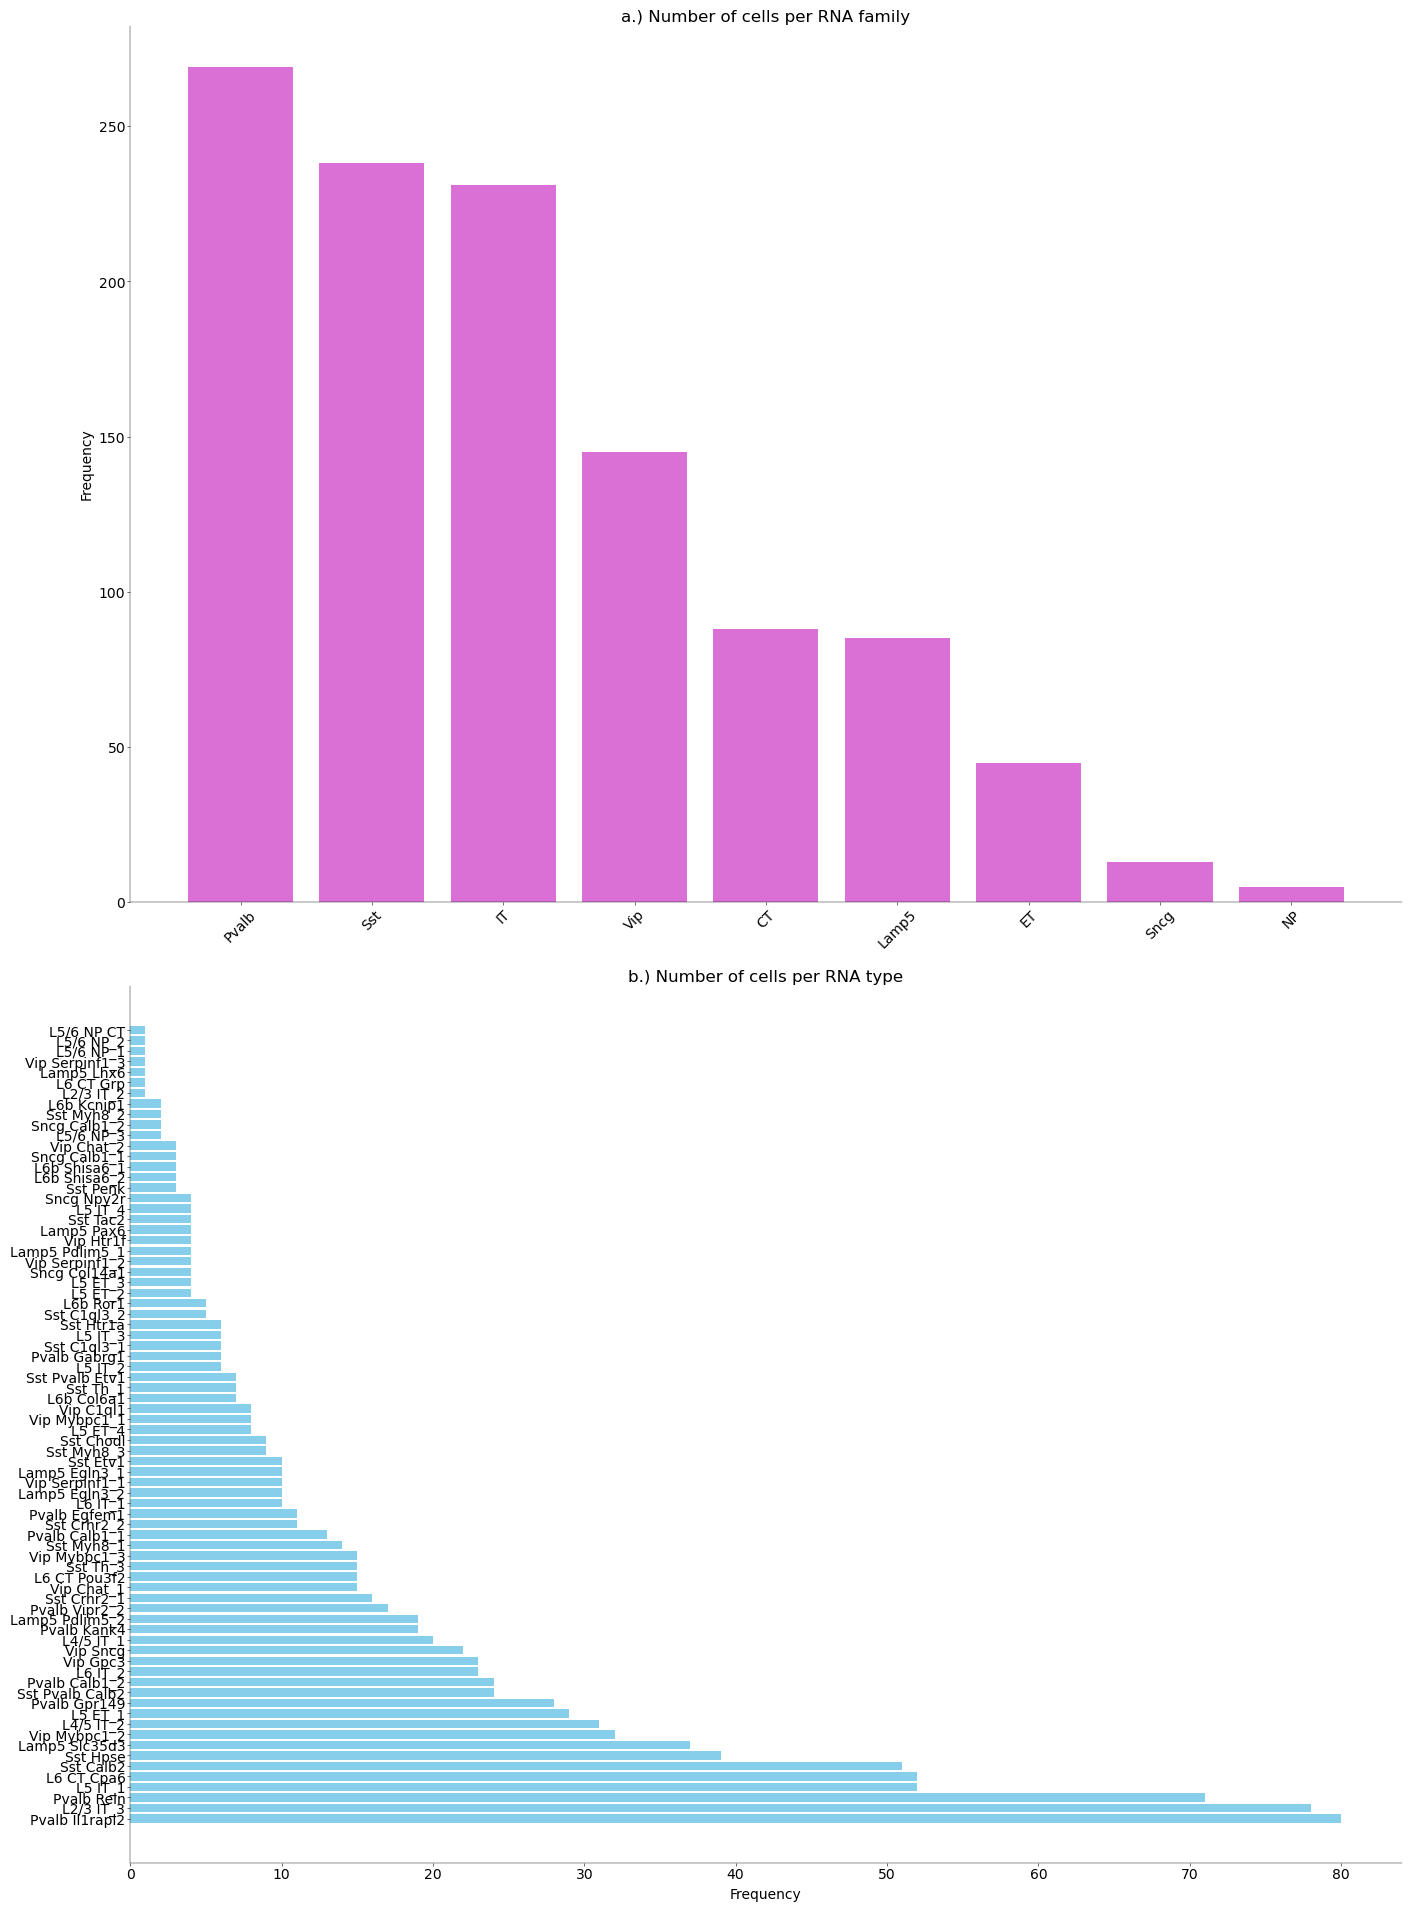

In [111]:
family_counts = filtered_adata.obs["rna_family"].value_counts()
type_counts = filtered_adata.obs["rna_type"].value_counts()

fig, axes = plt.subplots(
    2,
    1,
    figsize=(14, max(5, len(type_counts) * 0.25)),
    constrained_layout=True,
)

axes[0].bar(family_counts.index, family_counts.values, color="orchid")
axes[0].set_title("a.) Number of cells per RNA family")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis="x", rotation=45)

axes[1].barh(type_counts.index, type_counts.values, color="skyblue")
axes[1].set_title("b.) Number of cells per RNA type")
axes[1].set_xlabel("Frequency")

plt.show()

a.) The RNA families are not evenly distributed with most cells being labeled as Pvalb, Sst and IT. There are very few Sncg and NP cells. b.) The RNA types match the RNA families with the most cells stemming from specific Pvalb, IT and Sst RNA types. There are some Cell types that are only observed once. 

### Meta Data

Next we look at some meta data that could be interesting. We choose targeted layer and inferred layer as these relate to cortical position and laminar identity of cells. We also look at Soma depth as another indicator of spatial location. Lastly we look at Cre as another "sanity check" as it should also help with identifying RNA families.

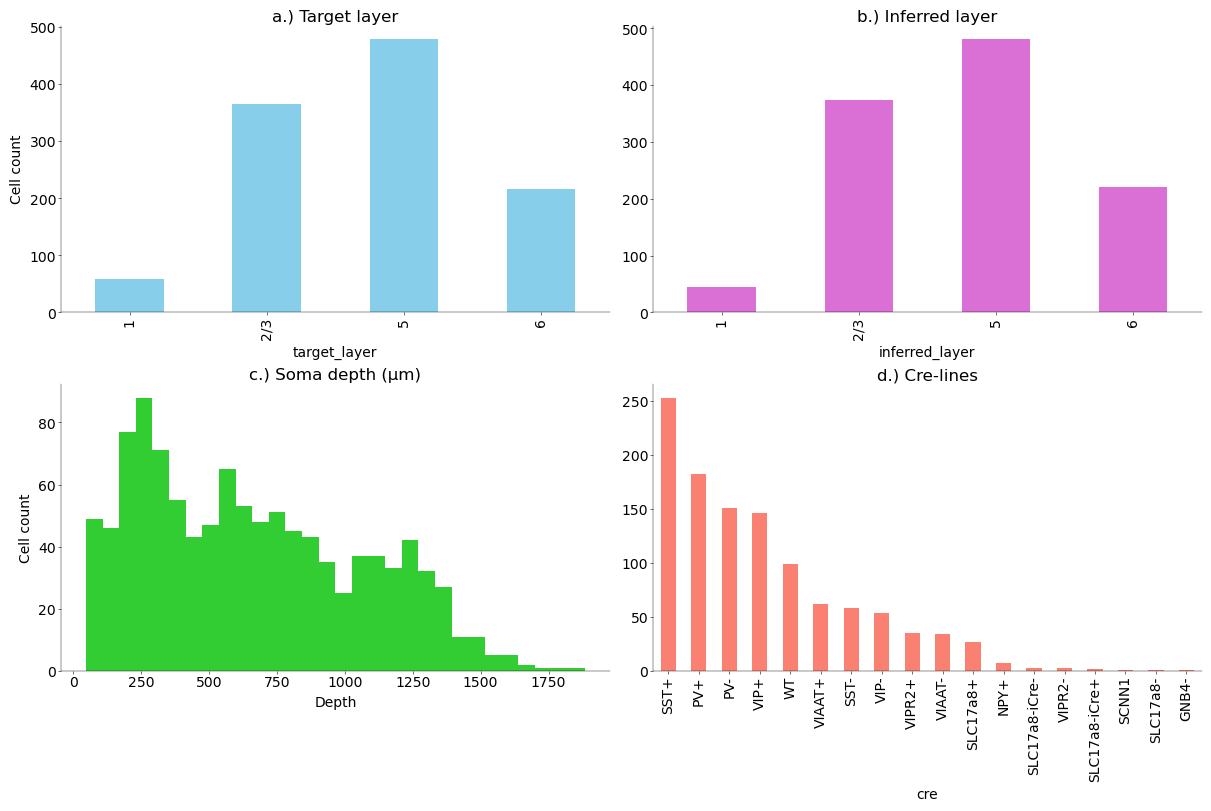

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

filtered_adata.obs["target_layer"].value_counts().sort_index().plot.bar(
    ax=axes[0, 0], color="skyblue"
)
axes[0, 0].set_title("a.) Target layer")
axes[0, 0].set_ylabel("Cell count")

filtered_adata.obs["inferred_layer"].value_counts().sort_index().plot.bar(
    ax=axes[0, 1], color="orchid"
)
axes[0, 1].set_title("b.) Inferred layer")

filtered_adata.obs["soma_depth"] = pd.to_numeric(
    filtered_adata.obs["soma_depth"], errors="coerce"
)
depth_values = filtered_adata.obs["soma_depth"].dropna()

axes[1, 0].hist(depth_values, bins=30, color="limegreen")
axes[1, 0].set_title("c.) Soma depth (µm)")
axes[1, 0].set_xlabel("Depth")
axes[1, 0].set_ylabel("Cell count")

filtered_adata.obs["cre"].value_counts().sort_values(ascending=False).plot.bar(
    ax=axes[1, 1], color="salmon"
)
axes[1, 1].set_title("d.) Cre-lines")

plt.show()

a,b.) Target layer and inferred layer are highly correlated. Most cells stem from layers 2/3 and 5. There are only few cells from layer 1. c.) Soma depth has a right skewed distribution. We will keep Soma depth for later analysis. d.) Cre-lines match the observed distribution of RNA family labels.

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

### Normalization & Transformation

We now perform normalization and transformation on the kept cells. We perform Raw, CPM and RPKM normalizations and log and sqrt transformations and compare how they differ in two dimensional visualization.

In [113]:
# Preserve raw counts
filtered_adata.raw = filtered_adata  # store raw counts & current var/obs

# Keep a counts layer
filtered_adata.layers["counts"] = filtered_adata.X.copy()

# --- CPM ---
sc.pp.normalize_total(
    filtered_adata, target_sum=1e6, inplace=True
)  # overwrites X
filtered_adata.layers["cpm"] = filtered_adata.X.copy()
# Restore raw counts in X (optional)
filtered_adata.X = filtered_adata.layers["counts"].copy()

# --- RPKM ---
# Ensure gene length is in bp
gene_length_bp = filtered_adata.var["exon_bp"].to_numpy()
# Guard against zeros
nonzero = gene_length_bp > 0
if not np.all(nonzero):
    # Option 1: Set zero lengths to np.nan then handle later
    gene_length_bp[~nonzero] = np.nan

counts = filtered_adata.raw.X  # raw counts
# Library sizes (cells x 1)
library_size = np.asarray(counts.sum(axis=1)).reshape(-1, 1)

# Compute RPKM (dense or sparse path)
if sparse.issparse(counts):
    # Convert to csr for efficient row scaling
    counts = counts.tocsr()
    # Divide each row by its library size
    row_scaled = counts.multiply(1 / library_size)
    # Divide by gene length (bp) and multiply by 1e9
    length_factor = gene_length_bp / 1e9  # denominator part
    rpkm = row_scaled.multiply(1 / length_factor)  # elementwise
    rpkm = rpkm.A  # dense array; omit if you want to keep sparse
else:
    rpkm = (counts * 1e9) / (library_size * gene_length_bp.reshape(1, -1))

filtered_adata.layers["rpkm"] = rpkm

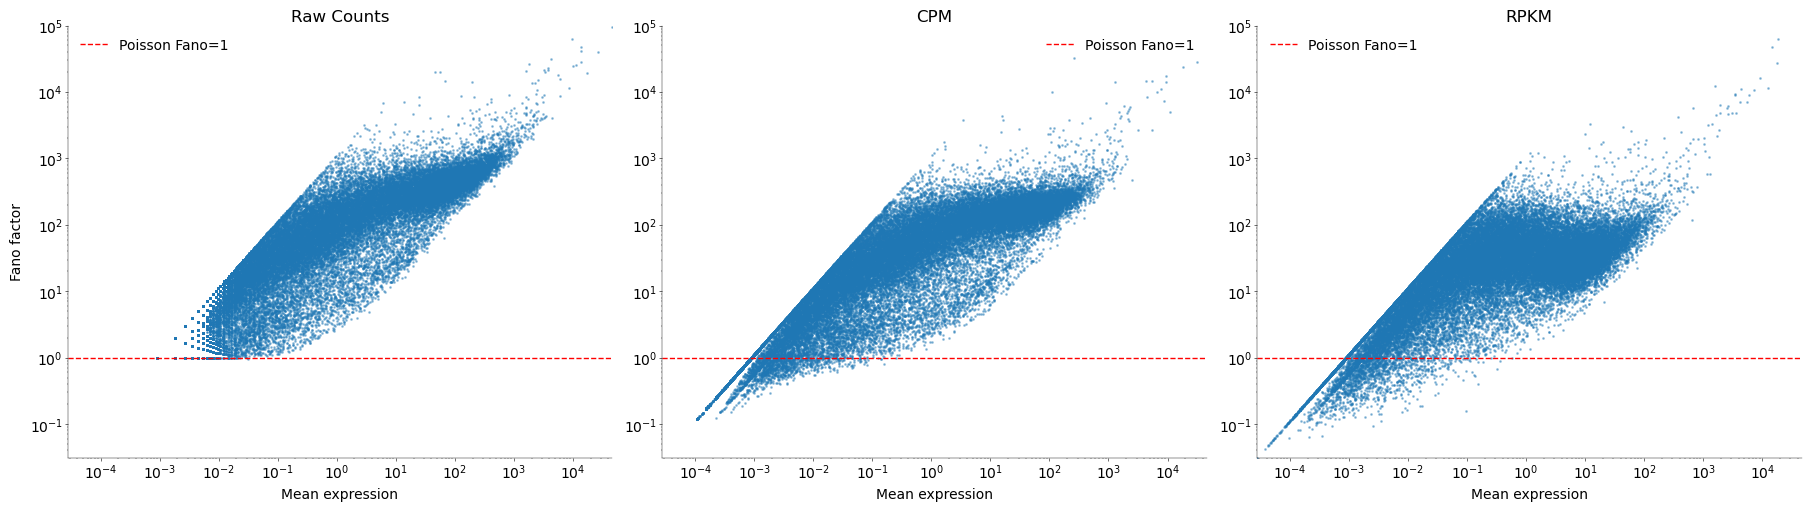

In [114]:
def mean_var_fano(mat, use_sparse=None):
    """
    Compute per-gene mean, variance (ddof=1), and Fano.
    Handles dense or CSR/CSC sparse matrices without densifying unless requested.
    """
    if use_sparse is None:
        use_sparse = sparse.issparse(mat)

    if use_sparse:
        mat = mat.tocsr()
        n_cells = mat.shape[0]
        mean = np.asarray(mat.mean(axis=0)).ravel()
        mat_sq = mat.copy()
        mat_sq.data = mat_sq.data**2
        ex2 = np.asarray(mat_sq.mean(axis=0)).ravel()
        var = (ex2 - mean**2) * n_cells / (n_cells - 1)
    else:
        mean = np.mean(mat, axis=0)
        var = np.var(mat, axis=0, ddof=1)

    fano = np.full(mean.shape, np.nan)
    valid = mean > 0
    fano[valid] = var[valid] / mean[valid]
    return mean, var, fano


def to_dense_if_needed(x):
    return x.toarray() if sparse.issparse(x) else x


raw_mat = filtered_adata.raw.X
cpm_mat = filtered_adata.layers["cpm"]
rpkm_mat = filtered_adata.layers["rpkm"]

mean_raw, var_raw, fano_raw = mean_var_fano(raw_mat)
mean_cpm, var_cpm, fano_cpm = mean_var_fano(cpm_mat)
mean_rpkm, var_rpkm, fano_rpkm = mean_var_fano(rpkm_mat)

all_means = np.concatenate(
    [
        mean_raw[~np.isnan(fano_raw)],
        mean_cpm[~np.isnan(fano_cpm)],
        mean_rpkm[~np.isnan(fano_rpkm)],
    ]
)
all_fanos = np.concatenate(
    [
        fano_raw[~np.isnan(fano_raw)],
        fano_cpm[~np.isnan(fano_cpm)],
        fano_rpkm[~np.isnan(fano_rpkm)],
    ]
)

positive_means = all_means[all_means > 0]
positive_fanos = all_fanos[all_fanos > 0]

xmin, xmax = positive_means.min(), positive_means.max()
ymin = max(positive_fanos.min(), 1e-2)
YMAX = 1e5  # CHANGED: fixed common upper limit

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

plots = [
    (mean_raw, fano_raw, "Raw Counts"),
    (mean_cpm, fano_cpm, "CPM"),
    (mean_rpkm, fano_rpkm, "RPKM"),
]

for ax, (m, f, title) in zip(axes, plots):
    mask = (~np.isnan(f)) & (m > 0) & (f > 0)
    ax.scatter(m[mask], f[mask], s=4, alpha=0.4)
    ax.axhline(1.0, color="red", lw=1, linestyle="--", label="Poisson Fano=1")
    ax.set_title(title)
    ax.set_xlabel("Mean expression")
    if ax is axes[0]:
        ax.set_ylabel("Fano factor")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, YMAX)
    ax.legend(frameon=False)

plt.show()

We again clearly observe that the data here does not follow a poisson distribution but rather something like a negative binomial. We continue with log1p and sqrt transformations of the cpm and rpkm normalized data.

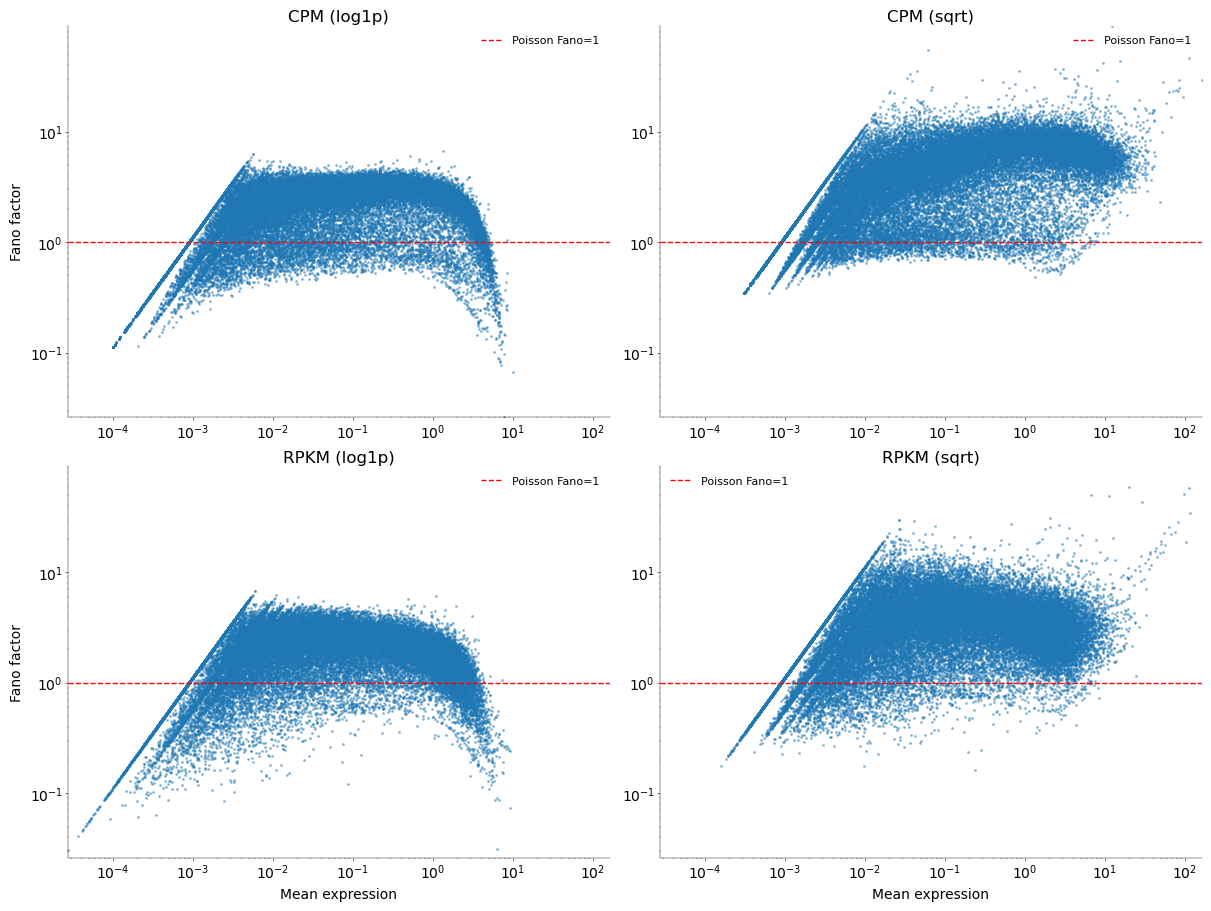

In [115]:
def transform(mat, kind):
    arr = mat.toarray() if sparse.issparse(mat) else mat
    if kind == "log1p":
        return np.log1p(arr)
    elif kind == "sqrt":
        return np.sqrt(arr)
    else:
        raise ValueError(f"Unknown transform: {kind}")


datasets = [("CPM", cpm_mat), ("RPKM", rpkm_mat)]
transforms = ["log1p", "sqrt"]

results = []
for name, mat in datasets:
    for tf in transforms:
        tmat = transform(mat, tf)
        mean, var, fano = mean_var_fano(tmat)  # <-- unpack 3 values
        results.append(
            {
                "dataset": name,
                "transform": tf,
                "mean": mean,
                "var": var,
                "fano": fano,
            }
        )

# Shared limits
all_means = np.concatenate([r["mean"][~np.isnan(r["fano"])] for r in results])
all_fanos = np.concatenate([r["fano"][~np.isnan(r["fano"])] for r in results])
pos_means = all_means[all_means > 0]
pos_fanos = all_fanos[all_fanos > 0]

xmin, xmax = pos_means.min(), pos_means.max()
ymin, ymax = pos_fanos.min(), pos_fanos.max()

# If you want a fixed ceiling:
# ymax = min(ymax, 1e5)

fig, axes = plt.subplots(
    len(datasets), len(transforms), figsize=(12, 9), constrained_layout=True
)


def add_panel(ax, mean_vals, fano_vals, title):
    mask = (~np.isnan(fano_vals)) & (mean_vals > 0) & (fano_vals > 0)
    ax.scatter(mean_vals[mask], fano_vals[mask], s=5, alpha=0.4)
    ax.axhline(1.0, color="red", lw=1, ls="--", label="Poisson Fano=1")
    ax.set_title(title)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.legend(frameon=False, fontsize=8)


for r in results:
    row = 0 if r["dataset"] == "CPM" else 1
    col = 0 if r["transform"] == "log1p" else 1
    add_panel(
        axes[row, col],
        r["mean"],
        r["fano"],
        f"{r['dataset']} ({r['transform']})",
    )

# Axis labels
axes[0, 0].set_ylabel("Fano factor")
axes[1, 0].set_ylabel("Fano factor")
axes[1, 0].set_xlabel("Mean expression")
axes[1, 1].set_xlabel("Mean expression")

plt.show()

We see that the log transformation is very similar between cpm and rpkm. For the sqrt transformation we see that high mean expression genes have high Fano factors for both normalization techniques. Generally the Genes with high fano factor are not strongly transformed when using sqrt.

### Highly Variable Genes and Dimensionality reduction.

Next we select High Variance Genes by Fano Factor. We will choose 1.000, 5.000 and 10.000 genes, to look at the influence of the amount of genes on the PCA. Then we perform PCA for dimensionality reduction and look at the 2d reconstruction.


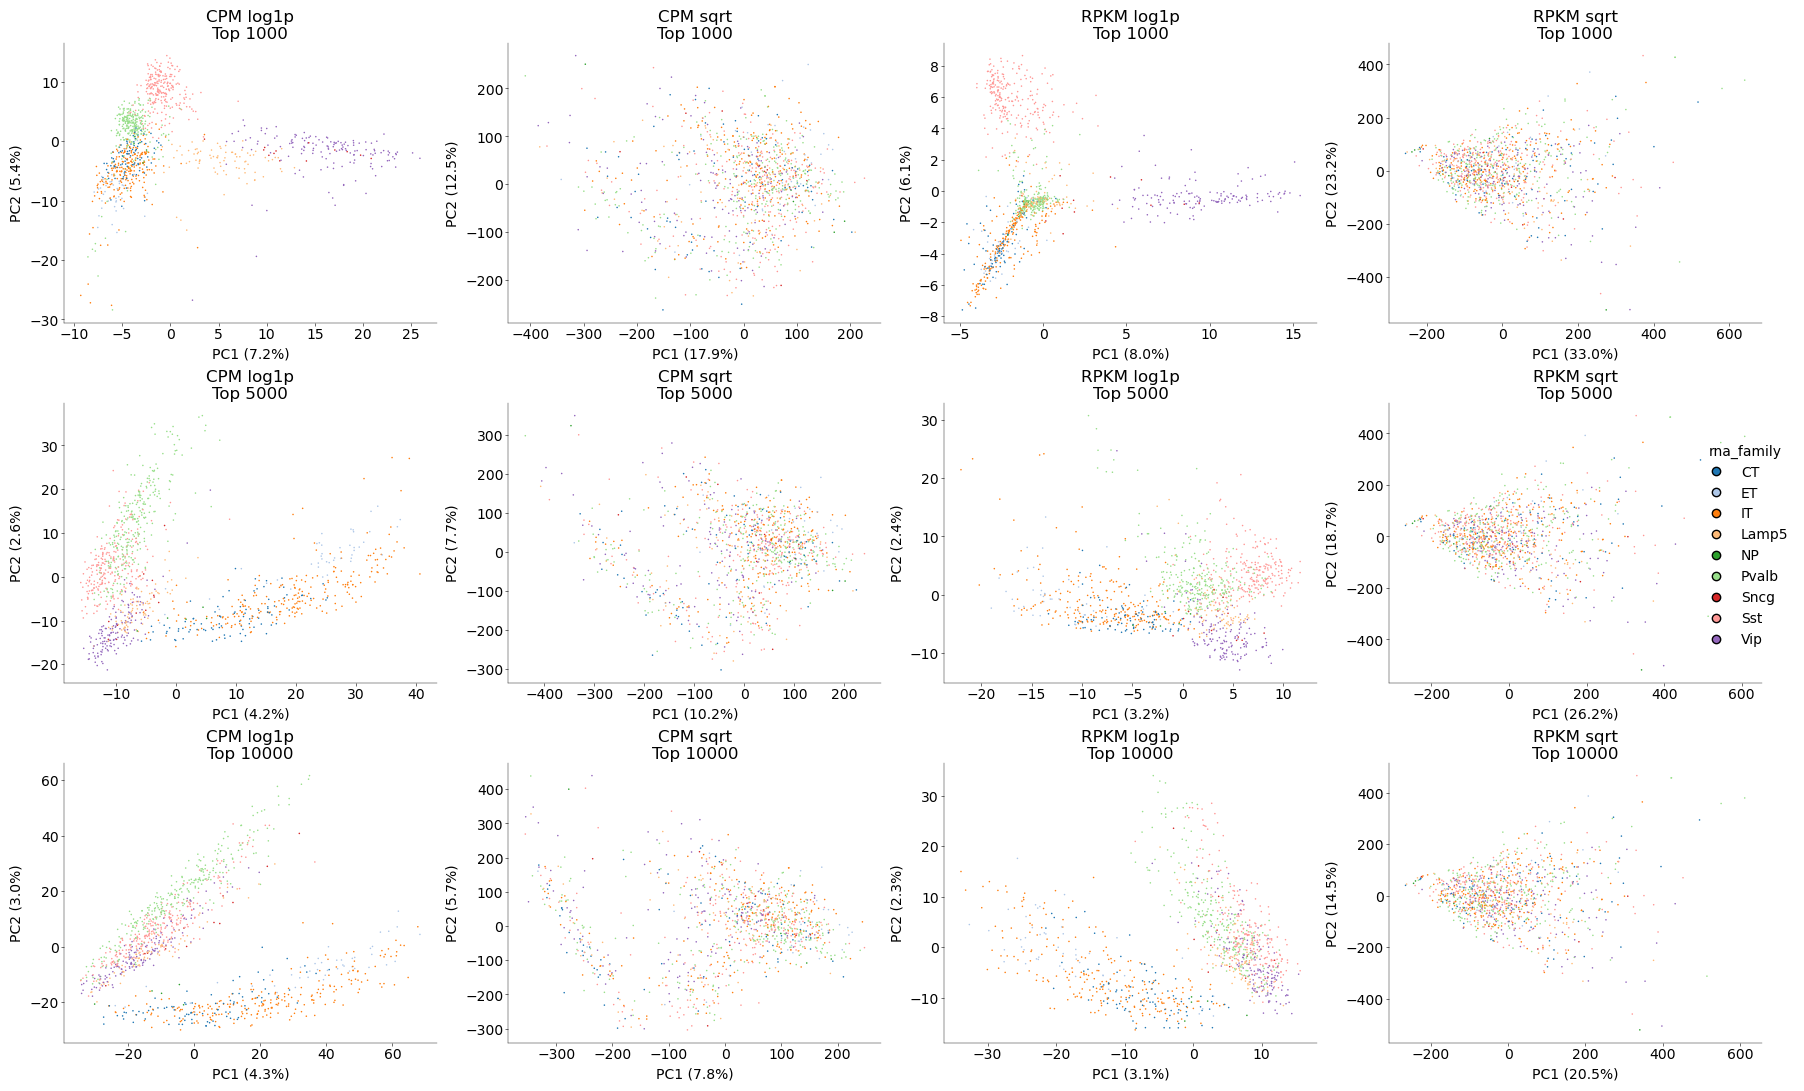

In [123]:
# ---------- Helper functions ----------
def transform_dense(mat, kind):
    arr = mat.toarray() if sparse.issparse(mat) else np.asarray(mat)
    if kind == "log1p":
        return np.log1p(arr)
    elif kind == "sqrt":
        return np.sqrt(arr)
    else:
        raise ValueError(f"Unknown transform {kind}")


def gene_fano_on_transformed(arr):
    mean = arr.mean(axis=0)
    var = arr.var(axis=0, ddof=1)
    fano = np.full_like(mean, np.nan, dtype=float)
    nz = mean > 0
    fano[nz] = var[nz] / mean[nz]
    return mean, fano


def select_top_genes(mean, fano, k):
    valid = ~np.isnan(fano)
    if valid.sum() < k:
        k = valid.sum()
    order = np.lexsort(
        (-mean[valid], -fano[valid])
    )  # primary fano desc, secondary mean desc
    valid_indices = np.flatnonzero(valid)
    return valid_indices[order[:k]]


def pca_2d(arr, n_components=2, random_state=0):
    pca = PCA(n_components=n_components, random_state=random_state)
    scores = pca.fit_transform(arr)
    return scores, pca.explained_variance_ratio_


# ---------- Data ----------
cpm_mat = filtered_adata.layers["cpm"]
rpkm_mat = filtered_adata.layers["rpkm"]

rna_family = filtered_adata.obs["rna_family"].astype("category")
families = rna_family.cat.categories
family_codes = rna_family.cat.codes.to_numpy()

# Color map
base_cmaps = [
    plt.get_cmap("tab20"),
    plt.get_cmap("tab20b"),
    plt.get_cmap("tab20c"),
]
colors = []
i = 0
while len(colors) < len(families):
    cm = base_cmaps[i % len(base_cmaps)]
    colors.extend([cm(j) for j in range(cm.N)])
    i += 1
colors = colors[: len(families)]
family_color_map = dict(zip(families, colors))
family_code_to_color = np.array([family_color_map[f] for f in families])[
    family_codes
]

datasets = {
    "CPM log1p": transform_dense(cpm_mat, "log1p"),
    "CPM sqrt": transform_dense(cpm_mat, "sqrt"),
    "RPKM log1p": transform_dense(rpkm_mat, "log1p"),
    "RPKM sqrt": transform_dense(rpkm_mat, "sqrt"),
}

# Stats
stats = {}
for name, arr in datasets.items():
    mean, fano = gene_fano_on_transformed(arr)
    stats[name] = {"mean": mean, "fano": fano}

gene_set_sizes = [1000, 5000, 10000]
pca_results = {}
for name, arr in datasets.items():
    mean = stats[name]["mean"]
    fano = stats[name]["fano"]
    for k in gene_set_sizes:
        top_idx = select_top_genes(mean, fano, k)
        sub_arr = arr[:, top_idx]
        scores, expl = pca_2d(sub_arr)
        pca_results[(k, name)] = (scores, expl, len(top_idx))


rows = len(gene_set_sizes)
cols = len(datasets)
fig, axes = plt.subplots(
    rows, cols, figsize=(4.4 * cols, 3.6 * rows), constrained_layout=True
)

if rows == 1:
    axes = np.array([axes])
if cols == 1:
    axes = axes[:, np.newaxis]


def scatter_panel(ax, scores, expl, title):
    ax.scatter(
        scores[:, 0],
        scores[:, 1],
        c=family_code_to_color,
        s=5,
        alpha=1,
        linewidths=0,
    )
    ax.set_title(title)
    xpad = (scores[:, 0].max() - scores[:, 0].min()) * 0.05
    ypad = (scores[:, 1].max() - scores[:, 1].min()) * 0.05
    ax.set_xlim(scores[:, 0].min() - xpad, scores[:, 0].max() + xpad)
    ax.set_ylim(scores[:, 1].min() - ypad, scores[:, 1].max() + ypad)
    return expl


for r, k in enumerate(gene_set_sizes):
    for c, name in enumerate(datasets.keys()):
        ax = axes[r, c]
        scores, expl, actual_k = pca_results[(k, name)]
        expl_ratio = scatter_panel(ax, scores, expl, f"{name}\nTop {actual_k}")
        # Individual axis labels for every subplot
        ax.set_xlabel(f"PC1 ({expl_ratio[0]*100:.1f}%)")
        ax.set_ylabel(
            f"PC2 ({expl_ratio[1]*100:.1f}%)"
        )  # <- keep or remove if you only want left column


handles = [
    matplotlib.lines.Line2D(
        [0],
        [0],
        marker="o",
        color="none",
        markerfacecolor=family_color_map[f],
        markersize=6,
        label=f,
    )
    for f in families
]

max_legend = 25
if len(handles) > max_legend:
    shown = handles[:max_legend]
    shown.append(
        matplotlib.lines.Line2D(
            [0],
            [0],
            marker="o",
            color="none",
            markerfacecolor="lightgray",
            markersize=6,
            label=f"... +{len(handles)-max_legend} more",
        )
    )
    handles = shown

fig.legend(
    handles=handles,
    loc="center right",
    title="rna_family",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

plt.show()

Generally we observe that the clustering is pretty bad which is expected here. It gets worse the more genes we include. This makes sense as the PCA is dominated by the high expression genes. This is especially bad for the sqrt transformation, which makes sense as we already observed that the high fano values are not strongly affected by the sqrt while they are more affected by the log transformation. 

### Two-dimensional Visualization

After the observations from before we decide to use the 1000 most variable genes from the cpm normalization with log1p transformation and dimensionality reduced to 50 PCs for the two dimensional visualization. We perform t-SNE and UMAP on different parameters and compare them using the k-NN accuracy, k-NN recall and silhouette score.

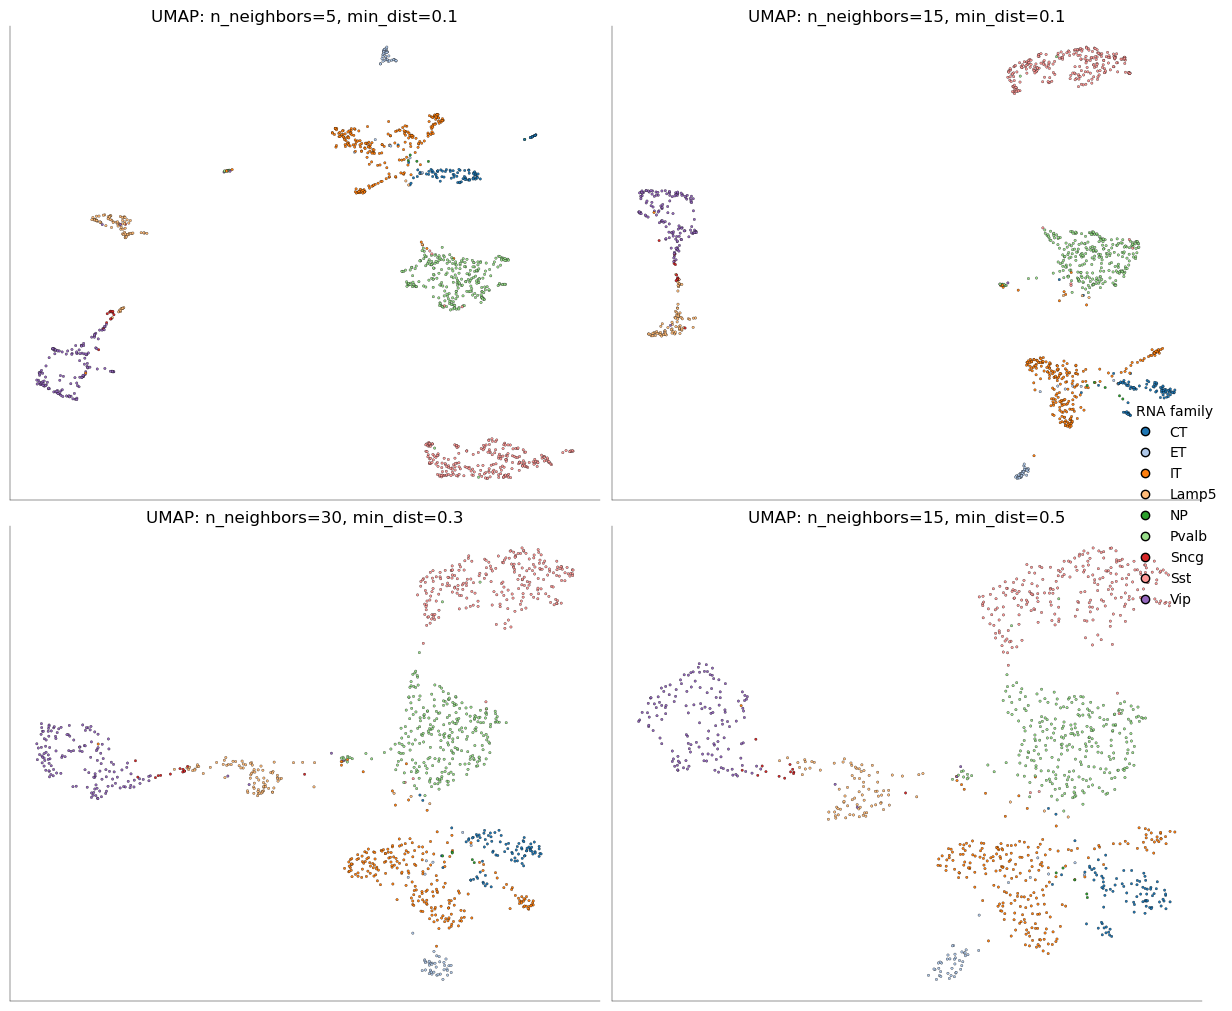

In [117]:
# Step 1: Get top 1000 HVGs from CPM log1p
top_1000_idx = select_top_genes(
    stats["CPM log1p"]["mean"], stats["CPM log1p"]["fano"], 1000
)
top_1000_hvg_matrix = datasets["CPM log1p"][:, top_1000_idx]

# Step 2: Reduce to 50 PCs
pca = PCA(n_components=50, random_state=42)
pca_50 = pca.fit_transform(top_1000_hvg_matrix)

# Step 3: Define UMAP parameter sets
param_grid = [
    {"n_neighbors": 5, "min_dist": 0.1},
    {"n_neighbors": 15, "min_dist": 0.1},
    {"n_neighbors": 30, "min_dist": 0.3},
    {"n_neighbors": 15, "min_dist": 0.5},
]

# Storage for embeddings
umap_embeddings = {}  # key: (n_neighbors, min_dist), value: 2D np.array

# Step 4: Plot UMAP embeddings with different parameters
nrows, ncols = 2, 2
fig, axes = plt.subplots(
    nrows, ncols, figsize=(12, 10), constrained_layout=True
)

for ax, params in zip(axes.ravel(), param_grid):
    key = (params["n_neighbors"], params["min_dist"])

    reducer = umap.UMAP(
        n_neighbors=params["n_neighbors"],
        min_dist=params["min_dist"],
        n_components=2,
        random_state=42,
        n_jobs=1,
    )
    embedding = reducer.fit_transform(pca_50)

    # Save embedding to dict
    umap_embeddings[key] = embedding

    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=family_code_to_color,
        s=12,
        alpha=1,
        edgecolors="k",
        linewidths=0.2,
    )
    ax.set_title(f"UMAP: n_neighbors={key[0]}, min_dist={key[1]}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

# Step 5: Legend
handles = [
    matplotlib.lines.Line2D(
        [0],
        [0],
        marker="o",
        color="none",
        markerfacecolor=family_color_map[f],
        markersize=6,
        label=f,
    )
    for f in families
]
max_legend = 25
if len(handles) > max_legend:
    handles = handles[:max_legend] + [
        matplotlib.lines.Line2D(
            [0],
            [0],
            marker="o",
            color="none",
            markerfacecolor="lightgray",
            markersize=6,
            label=f"... +{len(families) - max_legend} more",
        )
    ]

fig.legend(
    handles=handles,
    title="RNA family",
    loc="center right",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

plt.show()

The clustering does not work perfectly as we can observe, however there is difference between the "ground truth" labels. Overlaying clusters here could be due to some RNA families having very few observations. We generally observe that the denseness of the clusters depends on the min_dist parameter while the between cluster difference seems do depend on the n_neighbours parameter.

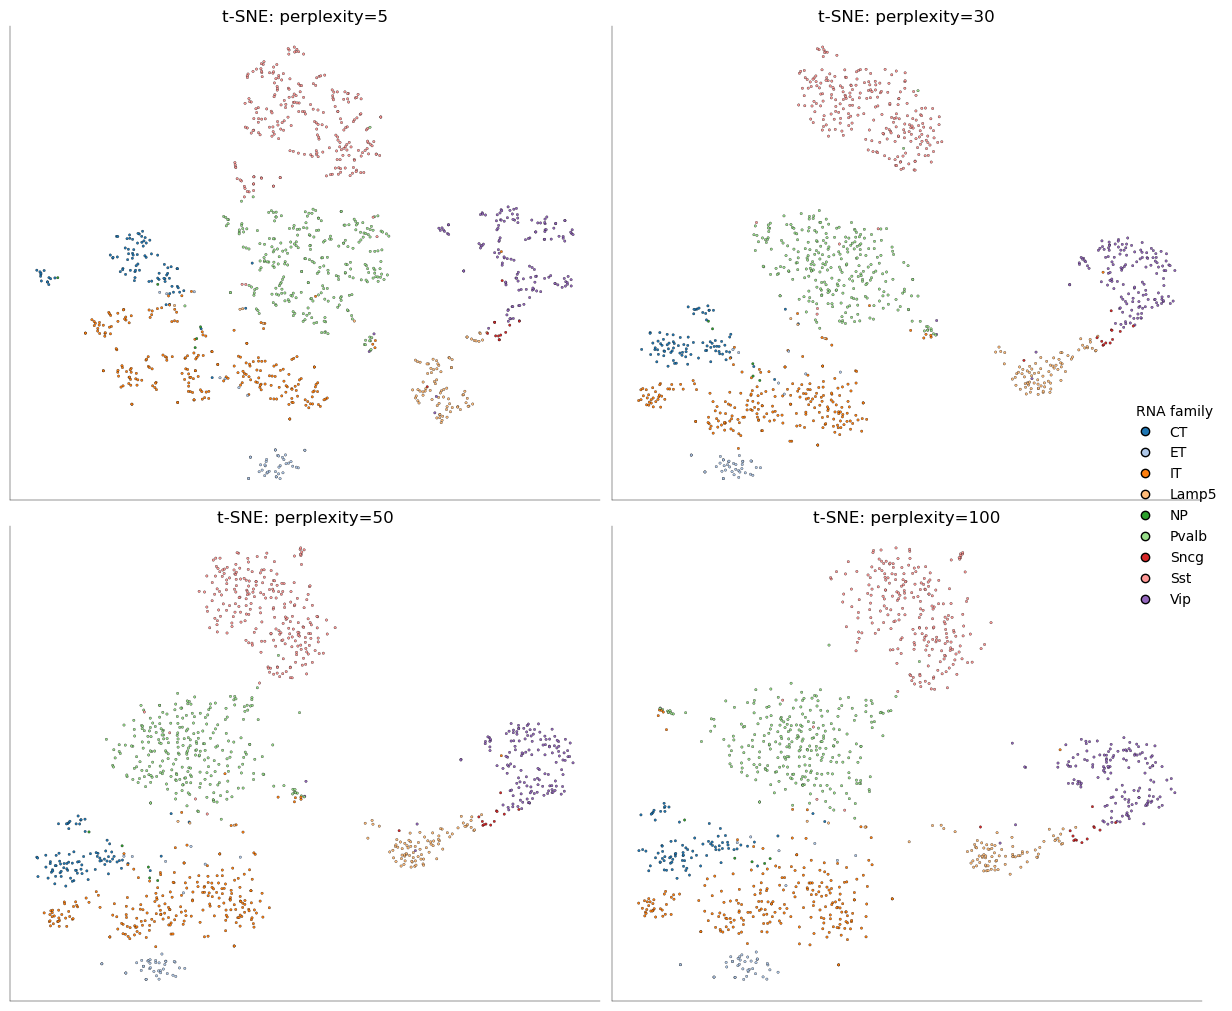

In [118]:
# Step 3: Perplexity values to explore
perplexities = [5, 30, 50, 100]

# Dictionary to store t-SNE embeddings
tsne_embeddings = {}

# Step 4: Plotting t-SNE results
nrows, ncols = 2, 2
fig, axes = plt.subplots(
    nrows, ncols, figsize=(12, 10), constrained_layout=True
)

for ax, perplexity in zip(axes.ravel(), perplexities):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        random_state=42,
        max_iter=1000,
    )
    embedding = tsne.fit_transform(pca_50)

    # Save embedding
    tsne_embeddings[f"tsne_perplexity{perplexity}"] = embedding

    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=family_code_to_color,
        s=12,
        alpha=1,
        edgecolors="k",
        linewidths=0.2,
    )
    ax.set_title(f"t-SNE: perplexity={perplexity}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

# Step 5: Legend
handles = [
    matplotlib.lines.Line2D(
        [0],
        [0],
        marker="o",
        color="none",
        markerfacecolor=family_color_map[f],
        markersize=6,
        label=f,
    )
    for f in families
]
max_legend = 25
if len(handles) > max_legend:
    handles = handles[:max_legend] + [
        matplotlib.lines.Line2D(
            [0],
            [0],
            marker="o",
            color="none",
            markerfacecolor="lightgray",
            markersize=6,
            label=f"... +{len(families) - max_legend} more",
        )
    ]

fig.legend(
    handles=handles,
    title="RNA family",
    loc="center right",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

plt.show()

The clustering again is not perfect but we can clearly see different clusters that seem to match the RNA family. There is little change to the clusters for higher perplexities. 

Next we compute the k-NN accuracy on the 2d-space, the k-NN recall from high Dimensional k-NN accuracy and the silhouette score.

In [119]:
filtered_adata.obs["rna_family"] = filtered_adata.obs["rna_family"].astype(
    "category"
)
labels = filtered_adata.obs["rna_family"].cat.codes.to_numpy()


def compute_knn_metrics(X_high, X_low, labels, k=10):
    # Nearest neighbors in high-dimensional space
    nn_high = NearestNeighbors(n_neighbors=k + 1).fit(X_high)
    high_idx = nn_high.kneighbors(return_distance=False)[:, 1:]

    # Nearest neighbors in low-dimensional embedding
    nn_low = NearestNeighbors(n_neighbors=k + 1).fit(X_low)
    low_idx = nn_low.kneighbors(return_distance=False)[:, 1:]

    # k-NN accuracy in 2D
    acc_2d = np.mean(
        [np.mean(labels[low_idx[i]] == labels[i]) for i in range(len(labels))]
    )

    # k-NN accuracy in high-D
    acc_high = np.mean(
        [np.mean(labels[high_idx[i]] == labels[i]) for i in range(len(labels))]
    )

    # k-NN recall: how much 2D neighbors recover high-D neighbors
    recall = np.mean(
        [
            len(set(high_idx[i]).intersection(low_idx[i])) / k
            for i in range(len(labels))
        ]
    )

    return acc_high, acc_2d, recall


# ---------- Run Analysis ----------
results = []

# UMAP embeddings
for (n_neighbors, min_dist), embedding in umap_embeddings.items():
    acc_high, acc_2d, recall = compute_knn_metrics(pca_50, embedding, labels)
    sil = silhouette_score(embedding, labels)
    results.append(
        {
            "Method": f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})",
            "kNN Acc (highD)": acc_high,
            "kNN Acc (2D)": acc_2d,
            "kNN Recall": recall,
            "Silhouette": sil,
        }
    )

# t-SNE embeddings
for perplexity, embedding in tsne_embeddings.items():
    acc_high, acc_2d, recall = compute_knn_metrics(pca_50, embedding, labels)
    sil = silhouette_score(embedding, labels)
    results.append(
        {
            "Method": f"t-SNE (perplexity={perplexity})",
            "kNN Acc (highD)": acc_high,
            "kNN Acc (2D)": acc_2d,
            "kNN Recall": recall,
            "Silhouette": sil,
        }
    )

# Create results table
df_results = pd.DataFrame(results)

df_results = df_results.drop(
    columns=["kNN Acc (highD)"]
)  # All tSNE and UMAP calculated on the same pca50 so this is constant

# Display styled table
df_results.style.format(precision=4).set_caption(
    "UMAP/t-SNE Evaluation Metrics"
)

,Method,kNN Acc (2D),kNN Recall,Silhouette
0,"UMAP (n_neighbors=5, min_dist=0.1)",0.9340,0.3318,0.4703
1,"UMAP (n_neighbors=15, min_dist=0.1)",0.9277,0.3384,0.4267
2,"UMAP (n_neighbors=30, min_dist=0.3)",0.9275,0.3157,0.3609
3,"UMAP (n_neighbors=15, min_dist=0.5)",0.9277,0.3256,0.3275
4,t-SNE (perplexity=tsne_perplexity5),0.9231,0.3644,0.3242
5,t-SNE (perplexity=tsne_perplexity30),0.9286,0.4028,0.3679
6,t-SNE (perplexity=tsne_perplexity50),0.9309,0.3983,0.3547
7,t-SNE (perplexity=tsne_perplexity100),0.9322,0.3808,0.3338


This shows that the clustering on the 2D space works actually very well accross all different parameter combinations. The kNN recall is clearly better for the t-SNE embedding, especially for the larger perplexities. The silhouette score preferes the denser clusters that are seen in the UMAP, especially with low min_dist parameter. 

We now keep the t-SNE with perplexity = 30 to look at different Electrophysiological and Meta data.

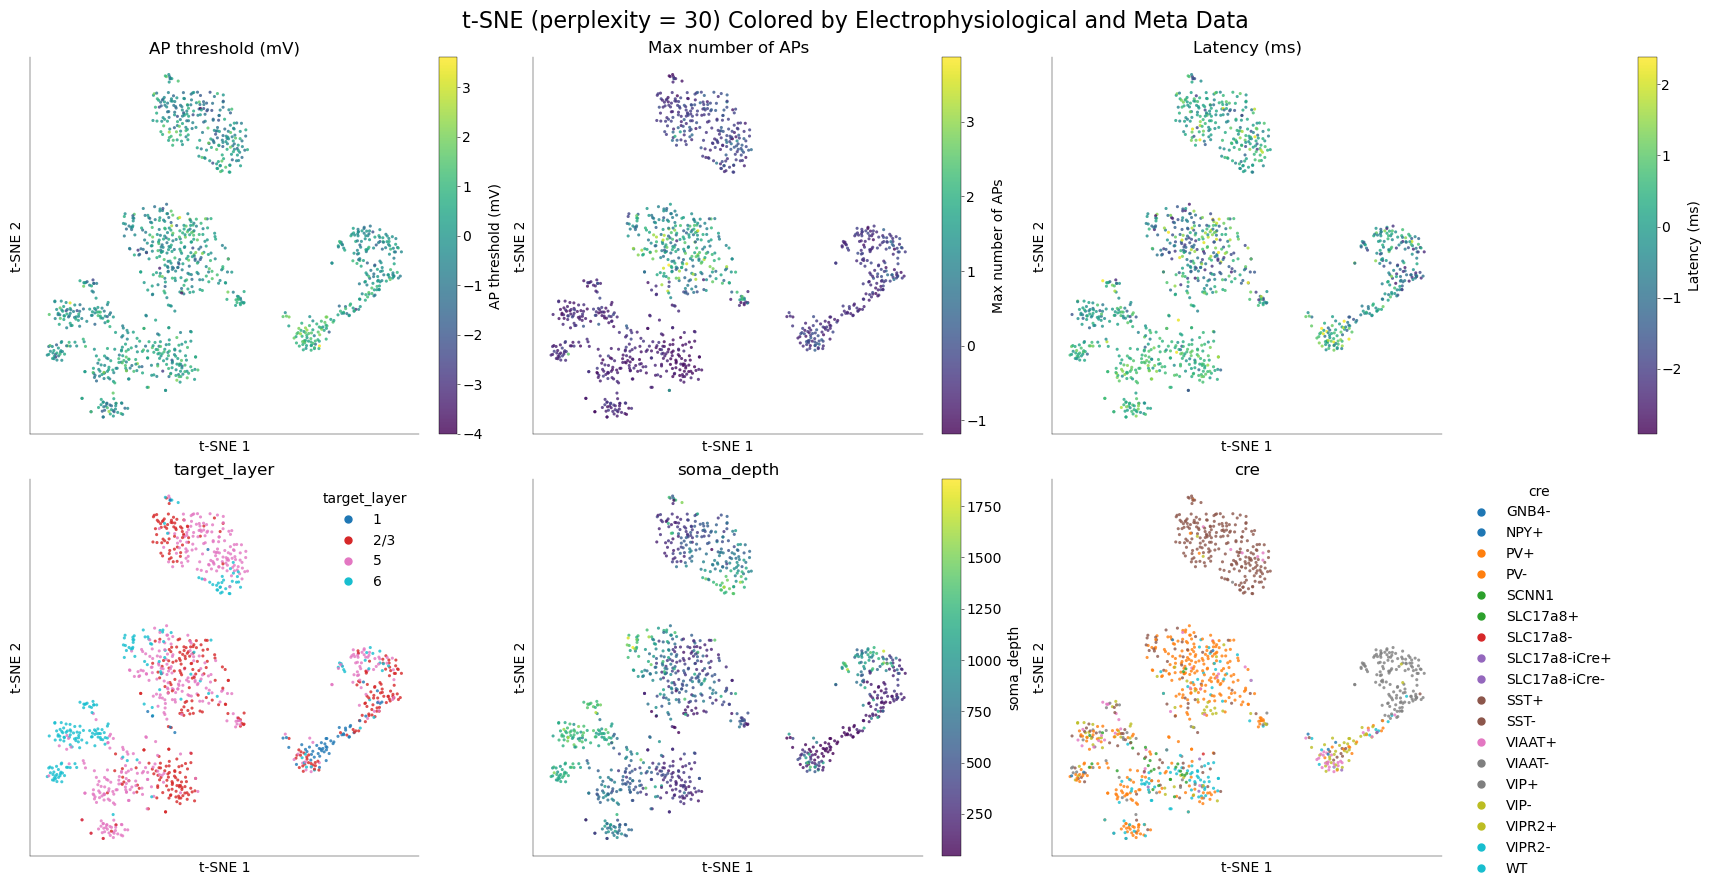

In [121]:
# Get the t-SNE embedding (perplexity = 30)
embedding_tsne_30 = tsne_embeddings["tsne_perplexity30"]

# Features to plot
features_to_plot = [
    "AP threshold (mV)",  # continuous
    "Max number of APs",  # continuous
    "Latency (ms)",  # continuous
    "target_layer",  # categorical
    "soma_depth",  # continuous
    "cre",  # categorical (legend needs adjustment)
]

# Create 2x3 grid
nrows, ncols = 2, 3
fig, axes = plt.subplots(
    nrows, ncols, figsize=(5 * ncols + 2, 4.5 * nrows), constrained_layout=True
)
axes = axes.ravel()

for ax, feature in zip(axes, features_to_plot):
    values = filtered_adata.obs[feature]

    # Determine if categorical
    if isinstance(values.dtype, pd.CategoricalDtype) or values.dtype == object:
        categories = pd.Categorical(values)
        values_mapped = categories.codes
        cmap = "tab10"
        label_values = categories.categories
    else:
        values_mapped = values
        cmap = "viridis"
        label_values = None

    # Scatter plot
    sc = ax.scatter(
        embedding_tsne_30[:, 0],
        embedding_tsne_30[:, 1],
        c=values_mapped,
        cmap=cmap,
        s=20,
        alpha=0.8,
        edgecolors="none",
    )
    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

    # Add colorbar or external legend
    if label_values is not None:
        handles = [
            plt.Line2D(
                [0],
                [0],
                marker="o",
                linestyle="None",
                color=sc.cmap(sc.norm(i)),
                label=str(cat),
                markersize=5,
            )
            for i, cat in enumerate(label_values)
        ]

        if feature == "cre":
            # Move legend outside the plot for "Cre"
            ax.legend(
                handles=handles,
                title=feature,
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                borderaxespad=0,
                frameon=False,
            )
        else:
            ax.legend(
                handles=handles, title=feature, loc="best", frameon=False
            )
    else:
        fig.colorbar(sc, ax=ax, label=feature)

# Super title
plt.suptitle(
    "t-SNE (perplexity = 30) Colored by Electrophysiological and Meta Data",
    fontsize=16,
)
plt.show()

Some features seem to not differentiate between the different clusters like the AP threshold and the latency. However we also observe some very interesting features. Firstly for the maximum Number of APs it seems like cells from the middle cluster are way more likely to fire (between 1 and 2 sd to the mean). For the target layer we observe that there are subclusters for the target layer within the clusters. There also looks to be a tight link of target layer to soma depth with cells with target layer 6 having higher soma depht which is very much expected.

### Clustering

Next we want to cluster our data and look wether it matches the "ground truth" labels

C:\Users\Florian\anaconda3\envs\nds_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Florian\anaconda3\envs\nds_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Florian\AppData\Local\Temp\ipykernel_15132\1393538091.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


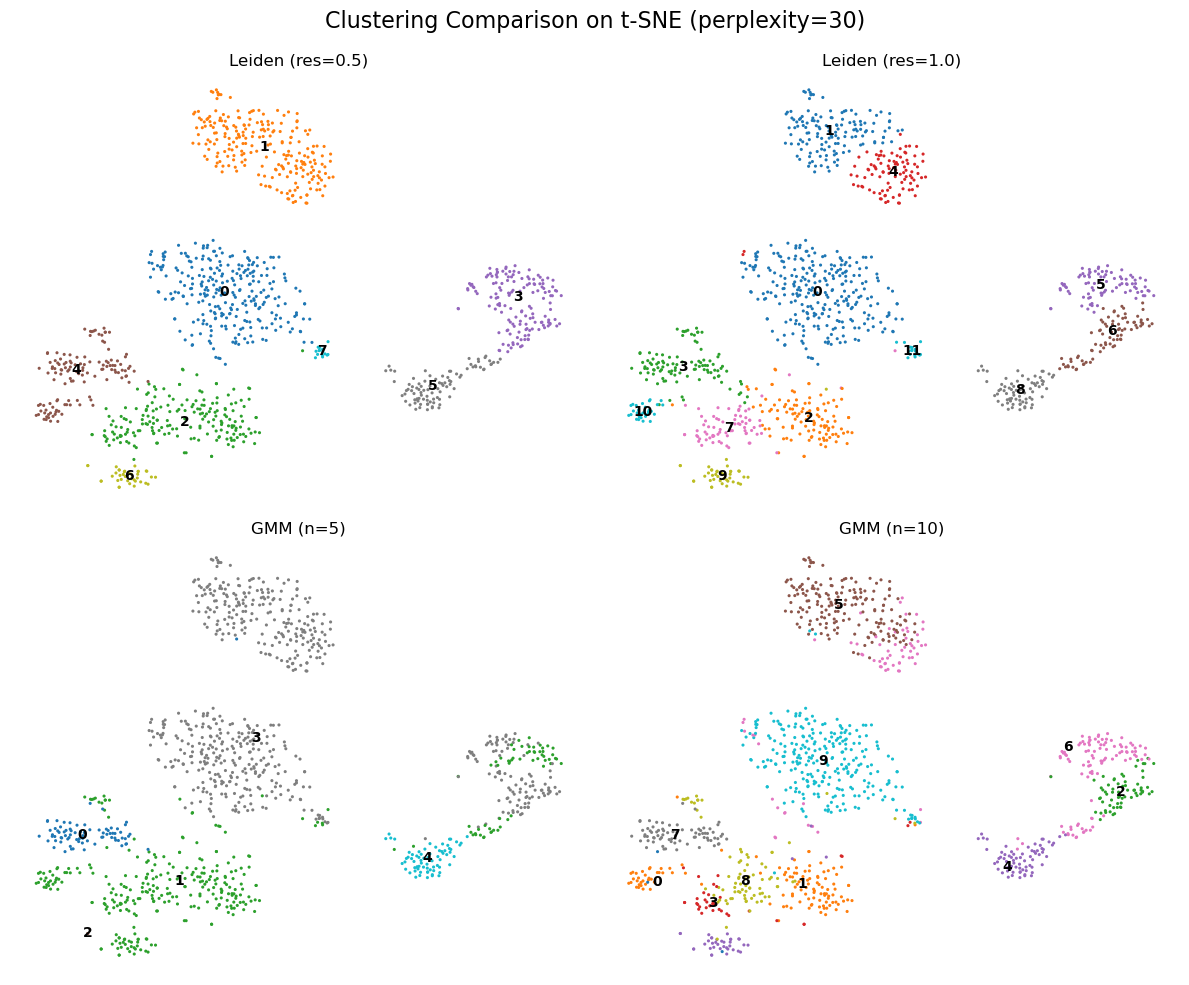

In [152]:
# Store PCA embedding
filtered_adata.obsm["X_pca"] = pca_50

# Ensure t-SNE embedding exists
filtered_adata.obsm["X_tsne"] = tsne_embeddings["tsne_perplexity30"]

# ---- 1. Leiden clustering at 2 resolutions ----
sc.pp.neighbors(filtered_adata, use_rep="X_pca", n_neighbors=15)

resolutions = [0.5, 1.0]
for res in resolutions:
    key = f"leiden_{res}"
    sc.tl.leiden(filtered_adata, resolution=res, key_added=key)

# ---- 2. GMM clustering at 2 component counts ----
X_scaled = StandardScaler().fit_transform(pca_50)
gmm_components = [5, 10]

for n in gmm_components:
    gmm = GaussianMixture(n_components=n, random_state=42, reg_covar=1e-3)
    labels = gmm.fit_predict(X_scaled)
    filtered_adata.obs[f"gmm_{n}"] = labels.astype(str)

# ---- 3. Plot 2x2 grid ----
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_configs = [
    ("leiden_0.5", "Leiden (res=0.5)"),
    ("leiden_1.0", "Leiden (res=1.0)"),
    ("gmm_5", "GMM (n=5)"),
    ("gmm_10", "GMM (n=10)"),
]

for ax, (key, title) in zip(axes.ravel(), plot_configs):
    sc.pl.tsne(
        filtered_adata,
        color=key,
        title=title,
        size=20,
        legend_loc="on data",
        frameon=False,
        palette="tab10",
        show=False,
        ax=ax,
    )

plt.suptitle("Clustering Comparison on t-SNE (perplexity=30)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust to make room for suptitle
plt.show()

**4) Clustering.** To find cell types in the RNA count data, you will need to look for clusters. Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2). Feel free to simplify the setup from the paper and not optimize over the set of important genes S but fix it instead, or skip the split and merge part of their clustering algorithm. A vanilla NBMM implementation should suffice. Take into account that the NBMM tries to cluster data that follows a negative binomial distribution. Therefore, it does not make sense to apply this clustering method to all kinds of normalized and transformed data. Please refer to the Harris et al. 2018 publication for the appropriate choice of normalization, and reflect on why this normalization makes sense. Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

C:\Users\Florian\anaconda3\envs\nds_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


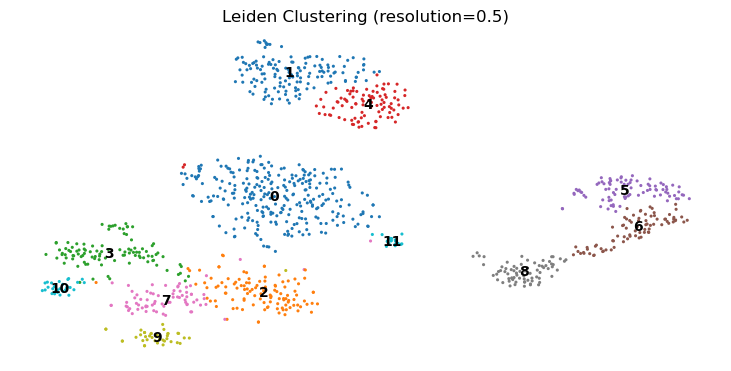

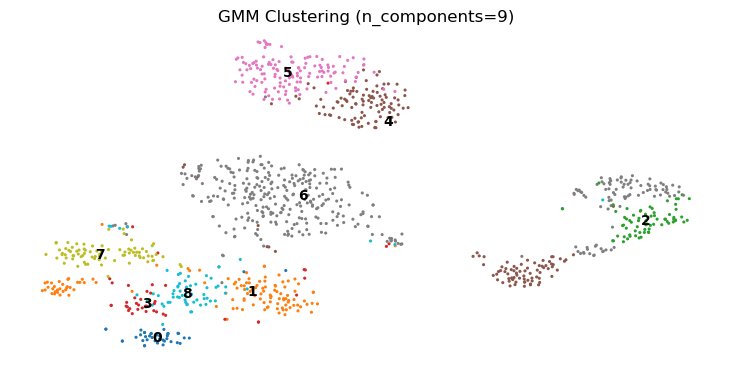

In [149]:
# Store PCA embedding in AnnData to enable Scanpy functions
filtered_adata.obsm["X_pca"] = pca_50

# 1. Leiden Clustering via Scanpy
sc.pp.neighbors(
    filtered_adata, use_rep="X_pca", n_neighbors=15
)  # use PCA space
sc.tl.leiden(filtered_adata, resolution=0.5, key_added="0.8")  # add label

# 2. GMM Clustering via sklearn
X_scaled = StandardScaler().fit_transform(pca_50)
gmm = GaussianMixture(n_components=9, random_state=42, reg_covar=1e-3)
gmm_labels = gmm.fit_predict(X_scaled)
filtered_adata.obs["gmm_6"] = gmm_labels.astype(
    str
)  # string for categorical coloring

# 3. Visualize both on existing t-SNE (perplexity = 30)
embedding_tsne_30 = tsne_embeddings["tsne_perplexity30"]

# Add t-SNE to AnnData for Scanpy plotting
filtered_adata.obsm["X_tsne"] = embedding_tsne_30

# Plot Leiden
sc.pl.tsne(
    filtered_adata,
    color="leiden_0.5",
    title="Leiden Clustering (resolution=0.5)",
    size=20,
    frameon=False,
    legend_loc="on data",
    palette="tab10",
)

# Plot GMM
sc.pl.tsne(
    filtered_adata,
    color="gmm_6",
    title="GMM Clustering (n_components=9)",
    size=20,
    frameon=False,
    legend_loc="on data",
    palette="tab10",
)

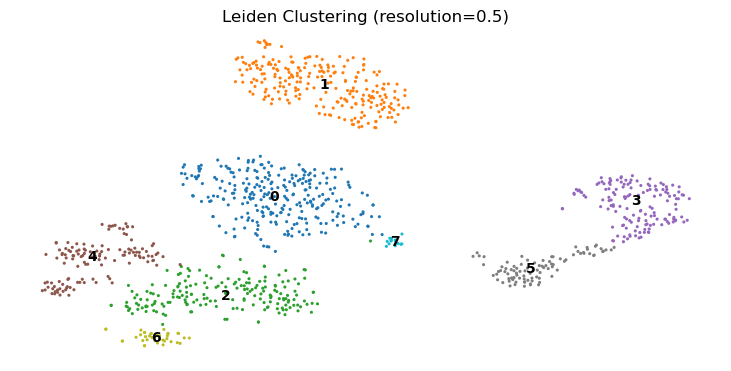

**5) Correlation between electrophysiological features and genes/PCs.** Finally, connect RNA counts and functional data: Most likely, there will be interesting relationships between the transcriptomic and electrophyiological features in this data. Find these correlations and a way of visualizing them. In studying correlations using the PCA-reduced version of the transcriptomics data, it could be interesting to study PC loadings to see which genes are dominating which PCs. For other advanced analyses, you can get inspitation from Kobak et al., 2021 (https://doi.org/10.1111/rssc.12494).